# Number of depot = 4

# Number of customer = 62

# Number of vehicles = [3,3,2,2]

# Demand and serive time of all customer are given

# Location of every node is given

# Assymetric distance matrix is considered by taking random value with a specified range about euclidean distance

# Vehicle maximum allowed distance and time is considered

# Vehicle capacity is given

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
import math as mt
import docplex.mp
from docplex.mp.model import Model
from cplex.callbacks import LazyConstraintCallback, UserCutCallback
from docplex.mp.callbacks.cb_mixin import ConstraintCallbackMixin

In [2]:
veh_speed = 35
P = 0.02           # percent of mean distance for interval of distance

In [4]:
depot_coor = pd.read_excel(r'C:\Users\shikh\OneDrive - IIT Kanpur\Desktop\Shikhar\Important Documents\Vehicle Routing Project\CVRP on 66 nodes\Data Set - 4_Depot 62_Customer.xlsx', sheet_name='Depot Details')
customer_det = pd.read_excel(r'C:\Users\shikh\OneDrive - IIT Kanpur\Desktop\Shikhar\Important Documents\Vehicle Routing Project\CVRP on 66 nodes\Data Set - 4_Depot 62_Customer.xlsx', sheet_name='Customer Details')
depot_coor_copy = depot_coor.drop('Depot', axis=1)
customer_det_copy = customer_det.drop('Customer', axis=1)
depot_coor.index = list(depot_coor['Depot'])
customer_det.index = list(customer_det['Customer'])

In [5]:
all_nodes_det = pd.concat([depot_coor_copy, customer_det_copy], ignore_index=True)
all_nodes_det.insert(0, 'Node', list(range(1, len(all_nodes_det) + 1)))
all_nodes_det.index = list(range(1, len(all_nodes_det) + 1))
all_nodes_det['Demand'] = all_nodes_det['Demand'].fillna(0)
all_nodes_det['Service Time'] = all_nodes_det['Service Time'].fillna(0)
all_nodes_det['Service Time'] = all_nodes_det['Service Time'].round(2)
all_nodes_det = all_nodes_det.astype({'Demand' : 'int'})
all_nodes_det

,Node,X coordinate,Y coordinate,No of vehicles,Capacity,Max allowed distance,Max allowed time,Demand,Service Time
1,1,76,75,3.0,100.0,120.0,6.0,0,0.00
2,2,25,61,3.0,100.0,120.0,6.0,0,0.00
3,3,34,15,2.0,100.0,120.0,6.0,0,0.00
4,4,75,26,2.0,100.0,120.0,6.0,0,0.00
5,5,60,14,NaN,NaN,NaN,NaN,11,1.06
...,...,...,...,...,...,...,...,...,...
62,62,20,71,NaN,NaN,NaN,NaN,16,1.39
63,63,94,45,NaN,NaN,NaN,NaN,5,0.81
64,64,31,41,NaN,NaN,NaN,NaN,22,0.90
65,65,40,49,NaN,NaN,NaN,NaN,17,1.02


In [6]:
coor_dic = {i : (all_nodes_det['X coordinate'][i], all_nodes_det['Y coordinate'][i]) for i in all_nodes_det['Node']}

In [7]:
print(coor_dic)

{1: (76, 75), 2: (25, 61), 3: (34, 15), 4: (75, 26), 5: (60, 14), 6: (46, 5), 7: (91, 14), 8: (70, 95), 9: (86, 31), 10: (20, 0), 11: (41, 55), 12: (21, 15), 13: (46, 1), 14: (95, 45), 15: (16, 89), 16: (41, 1), 17: (60, 94), 18: (55, 25), 19: (71, 41), 20: (39, 35), 21: (61, 70), 22: (80, 36), 23: (100, 26), 24: (65, 85), 25: (40, 51), 26: (19, 71), 27: (34, 50), 28: (36, 61), 29: (69, 50), 30: (61, 94), 31: (19, 11), 32: (51, 91), 33: (61, 54), 34: (76, 90), 35: (41, 75), 36: (35, 100), 37: (1, 40), 38: (15, 91), 39: (21, 11), 40: (79, 81), 41: (34, 36), 42: (74, 99), 43: (75, 14), 44: (65, 54), 45: (55, 10), 46: (100, 6), 47: (99, 91), 48: (25, 86), 49: (75, 16), 50: (30, 45), 51: (21, 85), 52: (75, 80), 53: (71, 35), 54: (56, 81), 55: (25, 76), 56: (85, 76), 57: (60, 34), 58: (41, 44), 59: (6, 55), 60: (60, 54), 61: (40, 96), 62: (20, 71), 63: (94, 45), 64: (31, 41), 65: (40, 49), 66: (56, 80)}


In [8]:
distance_matrix = pd.DataFrame(index=list(range(1, len(all_nodes_det) + 1)), columns=list(range(1, len(all_nodes_det) + 1)))
for i in all_nodes_det.index:
    x1, y1 = coor_dic[i]
    for j in range(i, len(all_nodes_det) + 1):
        if i == j:
            distance_matrix[i][i] = int(10e8)
            continue
        if i <= len(depot_coor) and j <= len(depot_coor):
            distance_matrix[i][j] = int(10e8)
            distance_matrix[j][i] = int(10e8)
            continue
        x2, y2 = coor_dic[j]
        euclidean_distance = np.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2))
        distance_matrix[i][j] = rnd.randint(mt.ceil((1 - P) * euclidean_distance), mt.ceil((1 + P) * euclidean_distance))
        distance_matrix[j][i] = rnd.randint(mt.ceil(0.98 * euclidean_distance), mt.ceil(1.02 * euclidean_distance))

travel_time_matrix = (distance_matrix / veh_speed)
for i in travel_time_matrix.index:
    travel_time_matrix[i] = travel_time_matrix[i].apply(lambda x : round(x, 2))

In [9]:
distance_matrix

,1,2,3,4,5,6,7,8,9,10,...,57,58,59,60,61,62,63,64,65,66
1,1000000000,1000000000,1000000000,1000000000,63,76,65,22,46,95,...,45,47,73,27,42,58,35,56,46,22
2,1000000000,1000000000,1000000000,1000000000,58,60,82,58,70,60,...,46,23,20,37,38,12,72,21,20,37
3,1000000000,1000000000,1000000000,1000000000,27,16,57,90,54,21,...,33,30,48,48,82,57,69,27,36,69
4,1000000000,1000000000,1000000000,1000000000,20,37,20,70,13,62,...,17,38,74,32,80,72,27,48,43,59
5,65,58,26,20,1000000000,17,32,84,32,44,...,21,36,68,41,87,71,46,39,42,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,58,11,58,70,72,73,91,55,79,73,...,55,35,21,45,32,1000000000,77,33,31,38
63,36,73,68,27,47,64,31,57,16,87,...,37,54,88,36,76,80,1000000000,65,56,51
64,56,22,26,46,41,40,66,68,57,44,...,31,11,29,32,56,32,64,1000000000,13,47
65,44,19,34,43,40,44,63,55,51,52,...,25,5,35,22,47,31,54,13,1000000000,35


In [10]:
travel_time_matrix

,1,2,3,4,5,6,7,8,9,10,...,57,58,59,60,61,62,63,64,65,66
1,28571428.57,28571428.57,28571428.57,28571428.57,1.80,2.17,1.86,0.63,1.31,2.71,...,1.29,1.34,2.09,0.77,1.20,1.66,1.00,1.60,1.31,0.63
2,28571428.57,28571428.57,28571428.57,28571428.57,1.66,1.71,2.34,1.66,2.00,1.71,...,1.31,0.66,0.57,1.06,1.09,0.34,2.06,0.60,0.57,1.06
3,28571428.57,28571428.57,28571428.57,28571428.57,0.77,0.46,1.63,2.57,1.54,0.60,...,0.94,0.86,1.37,1.37,2.34,1.63,1.97,0.77,1.03,1.97
4,28571428.57,28571428.57,28571428.57,28571428.57,0.57,1.06,0.57,2.00,0.37,1.77,...,0.49,1.09,2.11,0.91,2.29,2.06,0.77,1.37,1.23,1.69
5,1.86,1.66,0.74,0.57,28571428.57,0.49,0.91,2.40,0.91,1.26,...,0.60,1.03,1.94,1.17,2.49,2.03,1.31,1.11,1.20,1.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1.66,0.31,1.66,2.00,2.06,2.09,2.60,1.57,2.26,2.09,...,1.57,1.00,0.60,1.29,0.91,28571428.57,2.20,0.94,0.89,1.09
63,1.03,2.09,1.94,0.77,1.34,1.83,0.89,1.63,0.46,2.49,...,1.06,1.54,2.51,1.03,2.17,2.29,28571428.57,1.86,1.60,1.46
64,1.60,0.63,0.74,1.31,1.17,1.14,1.89,1.94,1.63,1.26,...,0.89,0.31,0.83,0.91,1.60,0.91,1.83,28571428.57,0.37,1.34
65,1.26,0.54,0.97,1.23,1.14,1.26,1.80,1.57,1.46,1.49,...,0.71,0.14,1.00,0.63,1.34,0.89,1.54,0.37,28571428.57,1.00


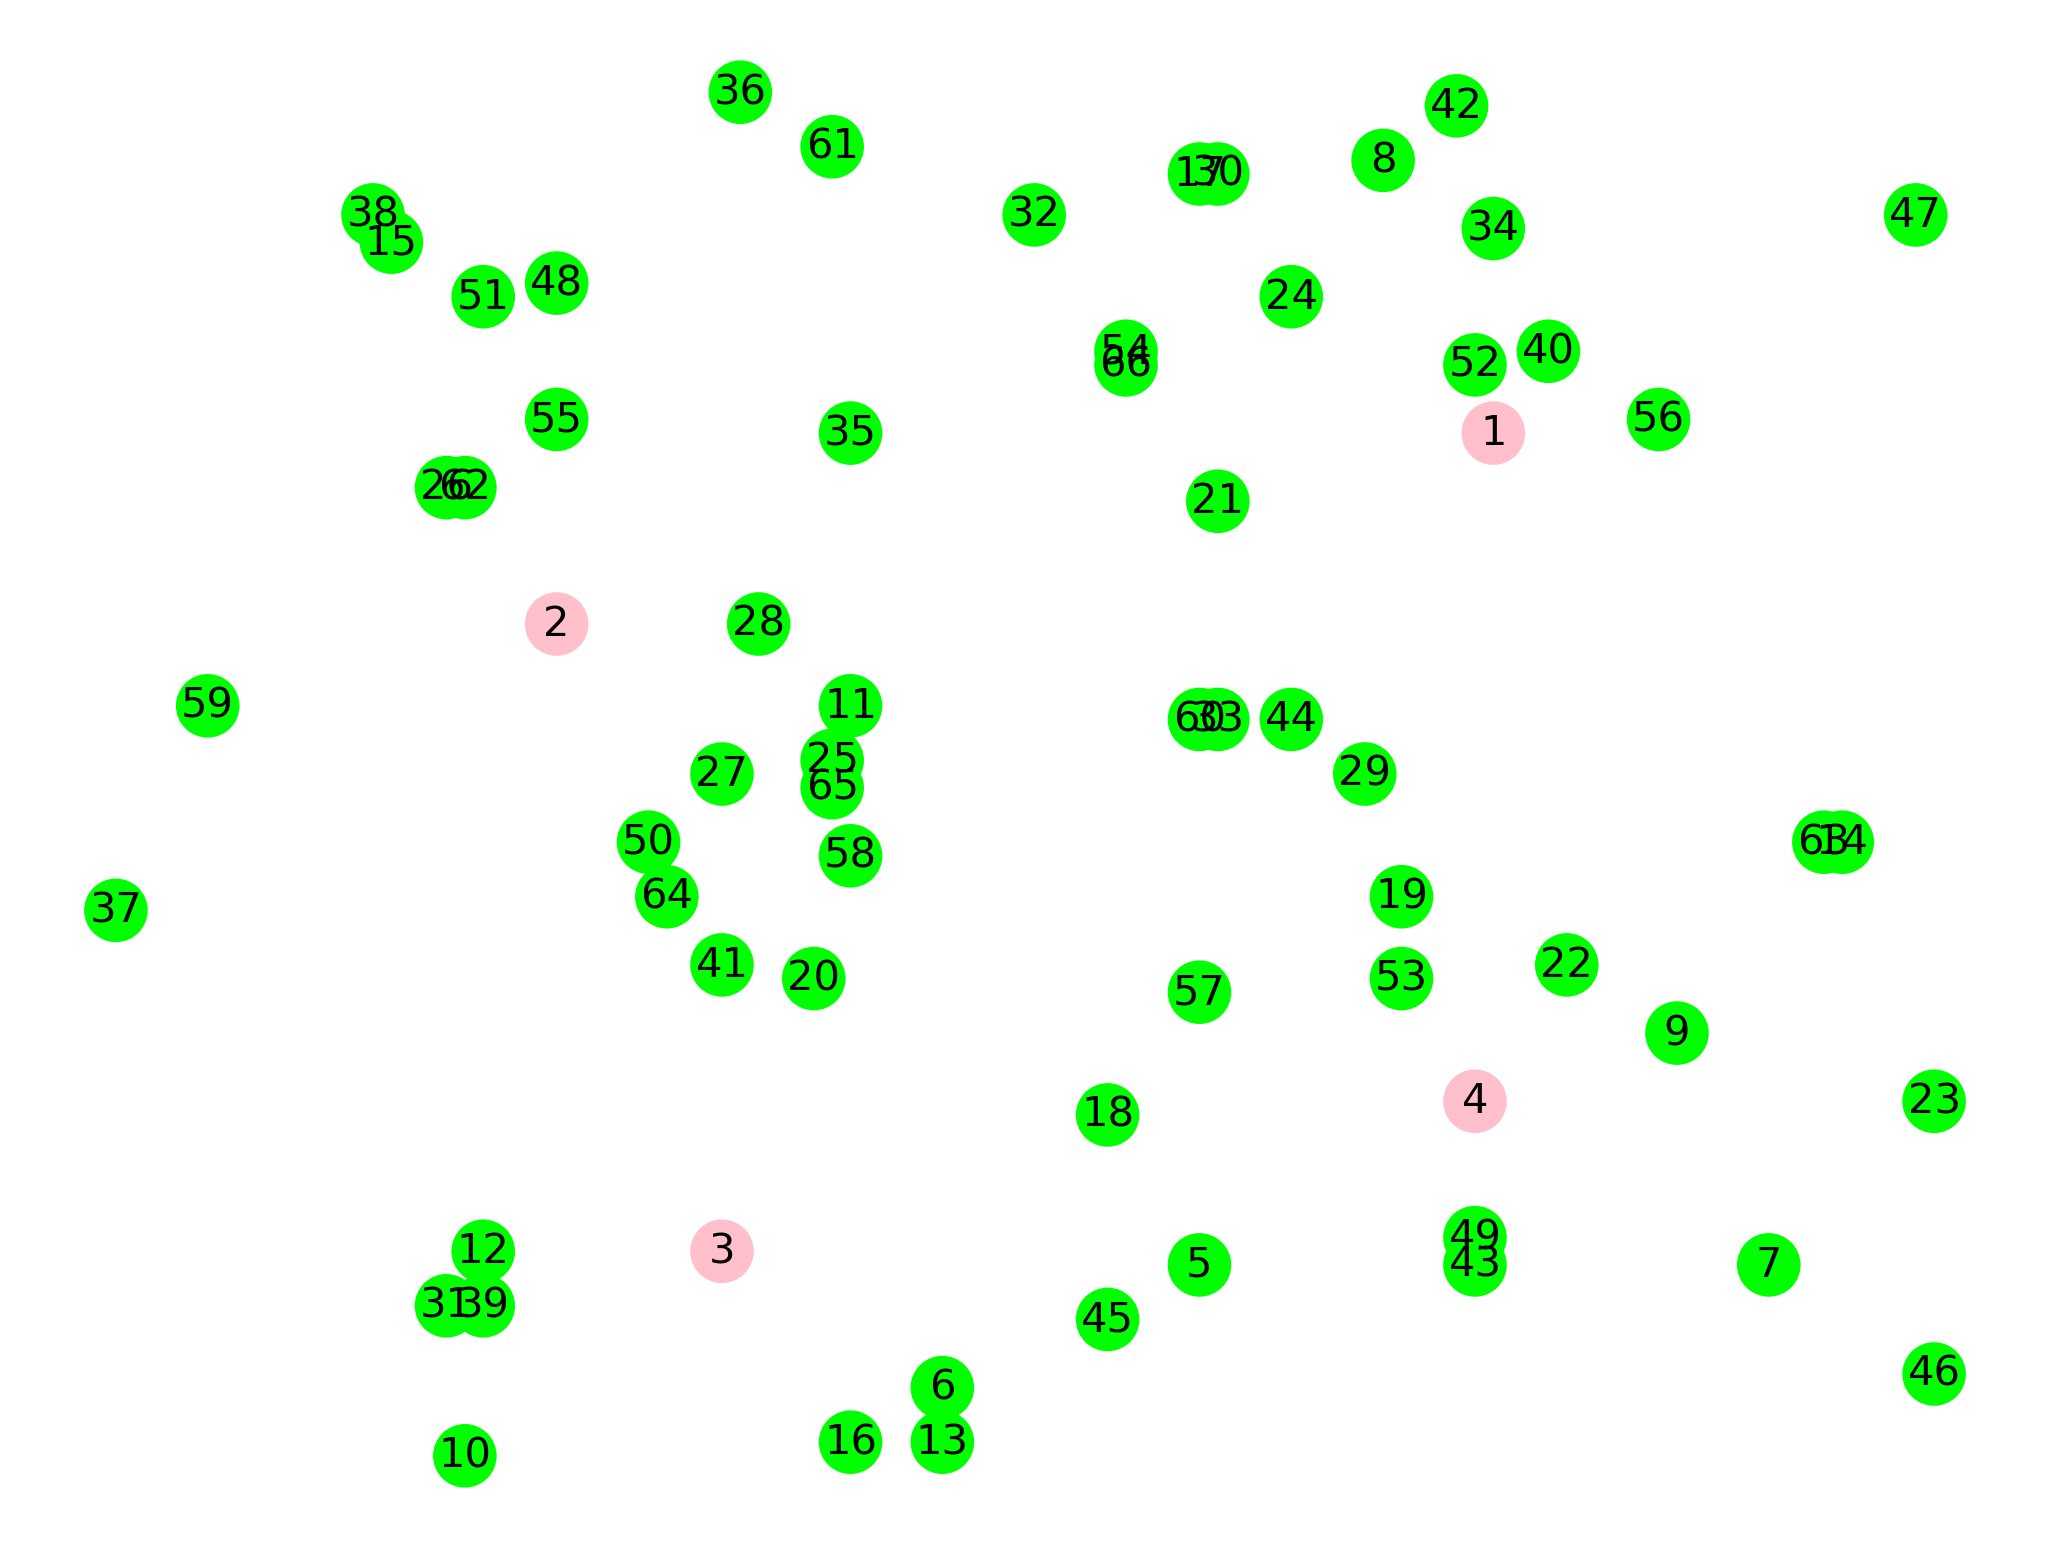

In [11]:
plt.figure(figsize=(8,6), dpi=250)
G = nx.DiGraph()
color_list = list()
G.add_nodes_from(list(range(1,len(all_nodes_det)+1)))
for node in G:
    if node in list(depot_coor['Depot']):
        color_list.append('pink')
    else:
        color_list.append('lime')
nx.draw(G, pos=coor_dic, node_size=300, node_color=color_list, with_labels=True)
plt.show()

In [12]:
m = len(depot_coor)         # Number of depot                                                                  
n = len(customer_det)       # Number of customer
L = [i for i in depot_coor['Depot']]        # List of depot
V = {i : depot_coor['No of vehicles'][i] for i in L}        # Number of vehicle at each depot
V_ = {i : [j for j in range(1, depot_coor['No of vehicles'][i] + 1)] for i in L}   # Set of vehicle for each depot as dictionary
C = [i for i in customer_det['Customer']]       # List of customers
N = [i for i in all_nodes_det['Node']]         # List of all nodes
CN = [i for i in N if i > len(L)]         # List of customer nodes
Q = depot_coor['Capacity'][1]          # Capacity of vehicle [same for all vehicles]
D = depot_coor['Max allowed distance'][1]           # Max allowed distance for vehicle [same for all vehicles]
T = depot_coor['Max allowed time'][1]        # Max allowed time [same for all vehicles]
q = {i: all_nodes_det['Demand'][i] for i in N}        # Demand dictionary of all nodes
s = {i : all_nodes_det['Service Time'][i] for i in N}        # Service time for all nodes

# Coordinates of all nodes
x_coor = {i : all_nodes_det['X coordinate'][i] for i in N}
y_coor = {i : all_nodes_det['Y coordinate'][i] for i in N}
x_coor_list = [v for v in x_coor.values()]
y_coor_list = [v for v in y_coor.values()]

In [13]:
index_set_cluster = [(i, l) for i in CN for l in L]
d = {(i,l) : distance_matrix[i][l] for i, l in index_set_cluster}

In [14]:
model = Model(name='Clustering_of_customer_nodes')

In [15]:
x = model.binary_var_dict(index_set_cluster,name='x')

In [16]:
model.minimize(model.sum(d[i, l] * x[i, l] for i, l in index_set_cluster))

In [17]:
c1 = model.add_constraints((model.sum(x[i,l] for l in L) == 1 for i in CN), names='mapping_constraints_1')
c2 = model.add_constraints((model.sum(x[i,l] * q[i] for i in CN) <= Q * V[l] for l in L), names='capacity_constraints')

In [18]:
model.print_information()

Model: Clustering_of_customer_nodes
 - number of variables: 248
   - binary=248, integer=0, continuous=0
 - number of constraints: 66
   - linear=66
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [19]:
a = model.solve(log_output=True)

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced MIP has 66 rows, 248 columns, and 496 nonzeros.
Reduced MIP has 248 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.11 sec. (0.35 ticks)
Found incumbent of value 3028.000000 after 0.33 sec. (0.92 ticks)
Probing time = 0.03 sec. (0.10 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 66 rows, 248 columns, and 496 nonzeros.
Reduced MIP has 248 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.41 ticks)
Probing time = 0.00 sec. (0.10 ticks)
Clique table members: 62.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (0.16 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt   

In [20]:
model.solve_status

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [21]:
model.print_solution()

objective: 1273
  x_5_4=1
  x_6_3=1
  x_7_4=1
  x_8_1=1
  x_9_4=1
  x_10_3=1
  x_11_2=1
  x_12_3=1
  x_13_3=1
  x_14_4=1
  x_15_2=1
  x_16_3=1
  x_17_1=1
  x_18_4=1
  x_19_4=1
  x_20_3=1
  x_21_1=1
  x_22_4=1
  x_23_4=1
  x_24_1=1
  x_25_2=1
  x_26_2=1
  x_27_2=1
  x_28_2=1
  x_29_4=1
  x_30_1=1
  x_31_3=1
  x_32_1=1
  x_33_1=1
  x_34_1=1
  x_35_2=1
  x_36_2=1
  x_37_2=1
  x_38_2=1
  x_39_3=1
  x_40_1=1
  x_41_3=1
  x_42_1=1
  x_43_4=1
  x_44_1=1
  x_45_3=1
  x_46_4=1
  x_47_1=1
  x_48_2=1
  x_49_4=1
  x_50_2=1
  x_51_2=1
  x_52_1=1
  x_53_4=1
  x_54_1=1
  x_55_2=1
  x_56_1=1
  x_57_4=1
  x_58_2=1
  x_59_2=1
  x_60_1=1
  x_61_1=1
  x_62_2=1
  x_63_4=1
  x_64_3=1
  x_65_2=1
  x_66_1=1


In [22]:
active_arcs = [a for a in index_set_cluster if x[a].solution_value > 0.9]

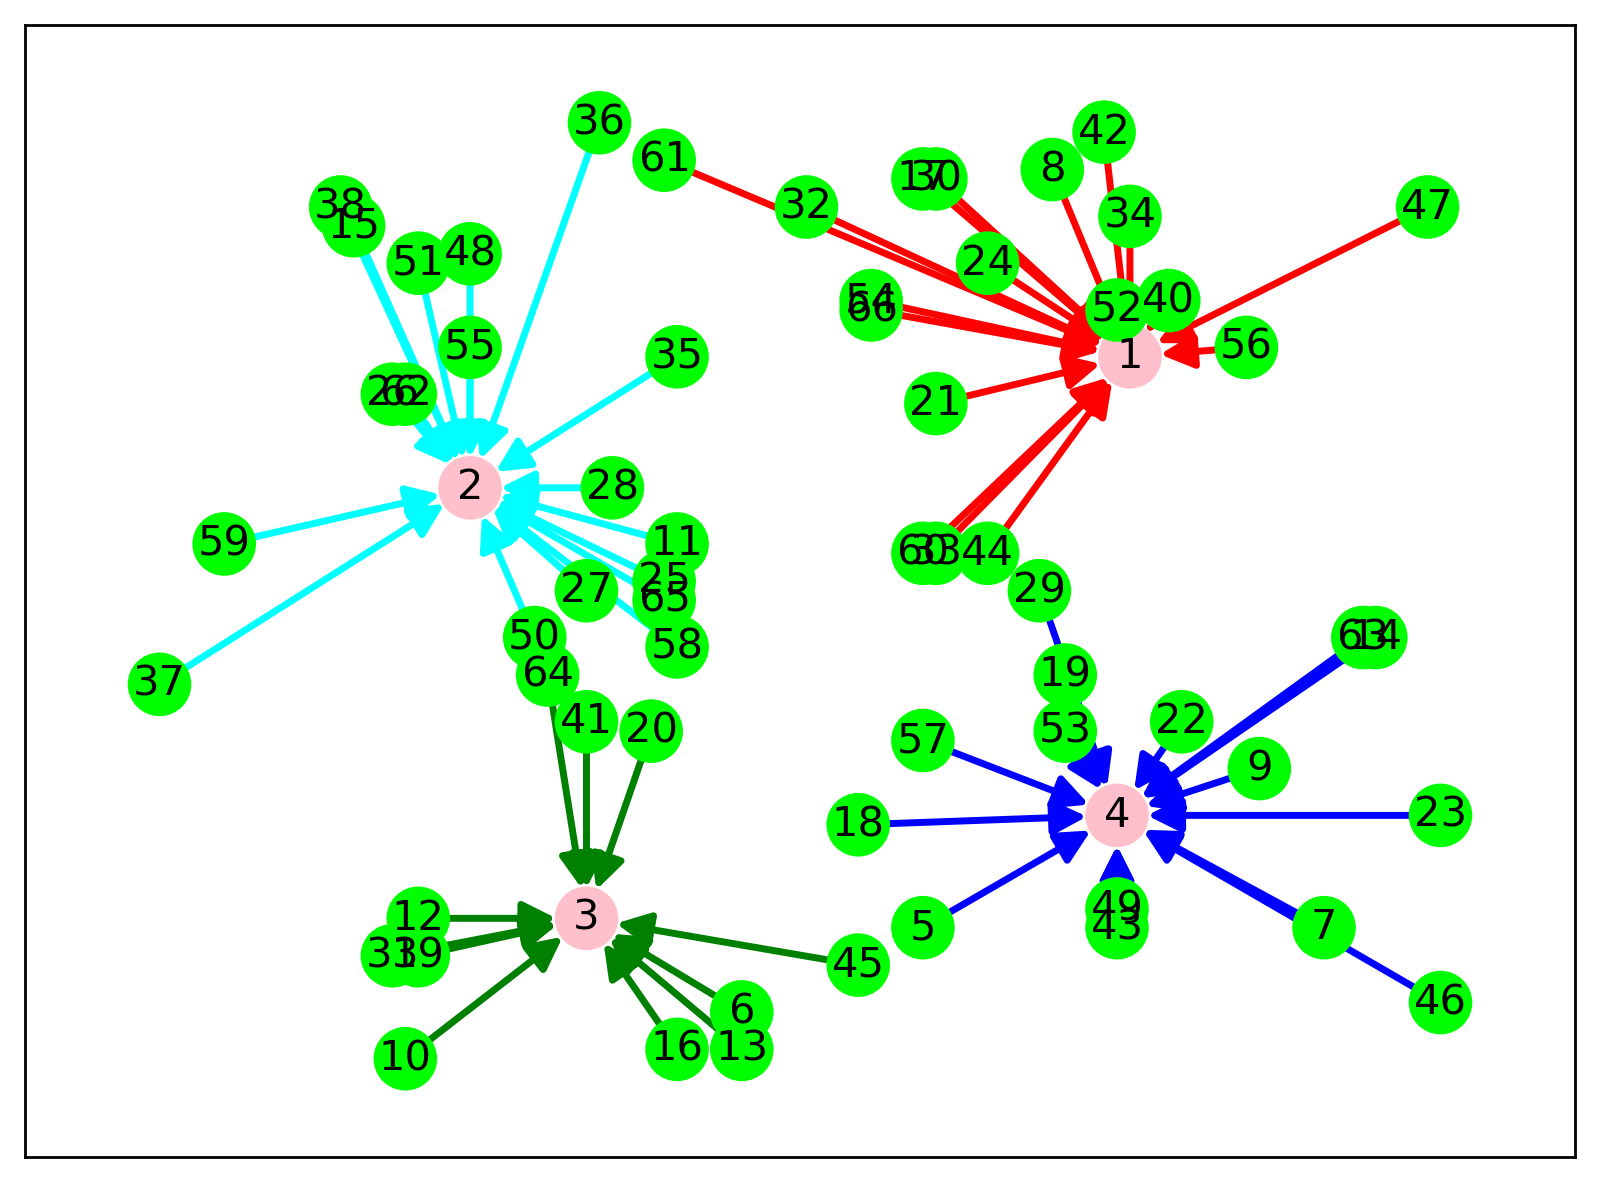

In [23]:
plt.figure(figsize=(8,6), dpi=250)
color_dic = {1 : 'red', 2 : 'cyan', 3 : 'green', 4 : 'blue'}
edge_color_list = []
edge_list = []
for i, l in active_arcs:
    edge_list.append((i,l,{'depot' : l}))
G.add_edges_from(edge_list)
for edge in G.edges(data=True):
    edge_color_list.append(color_dic[edge[2]['depot']])
nx.draw_networkx(G, pos=coor_dic, node_size=300, node_color=color_list, edge_color=edge_color_list, width=2, arrowsize=20, with_labels=True)
plt.show()

In [24]:
def search(route, sorted_saving_dict, distance, time, load, d, t):
    new_route = route.copy()
    if len(route) == 0:
        for key, value in sorted_saving_dict.items():
            node1 = key[0]
            node2 = key[1]
            if d[node1,node2] <= D and t[node1, node2] <= T and q[node1] + q[node2] <= Q:
                distance += d[node1,node2]
                time += t[node1, node2]
                load = q[node1] + q[node2]
                new_route.append(node1)
                new_route.append(node2)
                break
#             else:
#                 print('constraint breach details :')
#                 print(node1,node2,q[node1], q[node2])
#                 print(d[node1,node2], t[node1, node2], q[node1] + q[node2])
#                 print('---------------------------')
    else:
        head_node = route[0]
        tail_node = route[len(route)-1]
        for key, value in sorted_saving_dict.items():
            if key[0] == tail_node and key[1] not in new_route:
                next_node = key[1]
                if distance + d[tail_node, next_node] <= D and time + t[tail_node, next_node] <= T and load + q[next_node] <= Q:
                    distance += d[tail_node, next_node]
                    time += t[tail_node, next_node]
                    load += q[next_node]
                    new_route.append(next_node)
                    break
#                 else:
#                     print('constraint breach details :')
#                     print(tail_node, next_node,q[next_node])
#                     print(distance + d[tail_node, next_node], time + t[tail_node, next_node], load + q[next_node])
#                     print('---------------------------')
            elif key[1] == head_node and key[0] not in new_route:
                next_node = key[0]
                if distance + d[next_node, head_node] <= D and time + t[next_node, head_node] <= T and load + q[next_node] <= Q:
                    distance += d[next_node, head_node]
                    time += t[next_node, head_node]
                    load += q[next_node]
                    new_route.insert(0, next_node)
                    break
#                 else:
#                     print('constraint breach details :')
#                     print(next_node,head_node, q[next_node])
#                     print(distance + d[next_node, head_node], time + t[next_node, head_node], load + q[next_node])
#                     print('---------------------------')
    return new_route, distance, time, load

In [25]:
def search_variation(route, sorted_saving_dict, distance, time, load, d, t):
    new_route = route.copy()
    if len(route) == 0:
        for key, value in sorted_saving_dict.items():
            node1 = key[0]
            node2 = key[1]
            if d[node1,node2] <= D and t[node1, node2] <= T and q[node1] + q[node2] <= Q:
                distance += d[node1,node2]
                time += t[node1, node2]
                load = q[node1] + q[node2]
                new_route.append(node1)
                new_route.append(node2)
                break
#             else:
#                 print('constraint breach details :')
#                 print(node1,node2,q[node1], q[node2])
#                 print(d[node1,node2], t[node1, node2], q[node1] + q[node2])
#                 print('---------------------------')
    else:
        head_node = route[0]
        tail_node = route[len(route)-1]
        tail_side_extension_chance = 2
        head_side_extension_chance = 2
        for key, value in sorted_saving_dict.items():
            if key[0] == tail_node and key[1] not in new_route and tail_side_extension_chance > 0:
                next_node = key[1]
                if distance + d[tail_node, next_node] <= D and time + t[tail_node, next_node] <= T and load + q[next_node] <= Q:
                    distance += d[tail_node, next_node]
                    time += t[tail_node, next_node]
                    load += q[next_node]
                    new_route.append(next_node)
                    break
                else:
                    tail_side_extension_chance -= 1
#                     print(tail_side_extension_chance)
#                     print('constraint breach details :')
#                     print(tail_node, next_node,q[next_node])
#                     print(distance + d[tail_node, next_node], time + t[tail_node, next_node], load + q[next_node])
#                     print('---------------------------')
            elif key[1] == head_node and key[0] not in new_route and head_side_extension_chance > 0:
                next_node = key[0]
                if distance + d[next_node, head_node] <= D and time + t[next_node, head_node] <= T and load + q[next_node] <= Q:
                    distance += d[next_node, head_node]
                    time += t[next_node, head_node]
                    load += q[next_node]
                    new_route.insert(0, next_node)
                    break
                else:
                    head_side_extension_chance -= 1
#                     print(head_side_extension_chance)
#                     print('constraint breach details :')
#                     print(next_node,head_node, q[next_node])
#                     print(distance + d[next_node, head_node], time + t[next_node, head_node], load + q[next_node])
#                     print('---------------------------')
    return new_route, distance, time, load

In [26]:
def saving_heuristic(l):
    N = [l]
    CN = []
    for edge in G.edges():
        if edge[1] == l:
            N.append(edge[0])
            CN.append(edge[0])
    print(f'NUMBER OF NODES = {len(N)}')
    print(f'All nodes including depot = {N}')
    index_set = [(i,j) for i in N for j in N if i != j]
    d = {(i,j) : distance_matrix[i][j] for i, j in index_set}
    t = {(i,j) : travel_time_matrix[i][j] for i, j in index_set}
    saving_dict = {(i,j) : d[i,l] + d[l,j] - d[i,j] for i in CN for j in CN if i != j and d[i,l] + d[l,j] - d[i,j] > 0}
    sorted_saving_list = sorted(saving_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_saving_dict = {saving[0] : saving[1] for saving in sorted_saving_list}
#     print(sorted_saving_dict)
    route_master = {}
    for k in V_[l]:
        route = list()
        load = 0
        time = 0
        distance = 0
        new_route, distance, time, load = search(route, sorted_saving_dict, distance, time, load, d, t)
#         print('new_route = ', new_route)
#         print('INSIDE WHILE LOOP')
        while(len(route) < len(new_route)):
            route = new_route
#             print('old_route = ', route, 'old_distance = ', distance, 'old_time = ', time, 'old_load = ', load)
            new_route, distance, time, load = search(route, sorted_saving_dict, distance, time, load, d, t)
#             print('new_route = ', new_route, 'new_distance = ', distance, 'new_time = ', time, 'new_load = ', load)
#         print('WHILE LOOP BREAKS \n\n')
        route_master[k] = {'route' : new_route, 'distance' : distance, 'time' : time, 'load' : load}
        sorted_saving_dict = {key : value for key, value in sorted_saving_dict.items() if key[0] not in new_route and key[1] not in new_route}
    nodes_covered = [node for value in route_master.values() for node in value['route']]
    nodes_left = [node for node in CN if node not in nodes_covered]
#     print('nodes_left_to_map = ',nodes_left)
    return route_master, nodes_left

In [27]:
def saving_heuristic_variation(l):
    N = [l]
    CN = []
    for edge in G.edges():
        if edge[1] == l:
            N.append(edge[0])
            CN.append(edge[0])
    print(f'NUMBER OF NODES = {len(N)}')
    print(f'All nodes including depot = {N}')
    index_set = [(i,j) for i in N for j in N if i != j]
    d = {(i,j) : distance_matrix[i][j] for i, j in index_set}
    t = {(i,j) : travel_time_matrix[i][j] for i, j in index_set}
    saving_dict = {(i,j) : d[i,l] + d[l,j] - d[i,j] for i in CN for j in CN if i != j and d[i,l] + d[l,j] - d[i,j] > 0}
    sorted_saving_list = sorted(saving_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_saving_dict = {saving[0] : saving[1] for saving in sorted_saving_list}
#     print(sorted_saving_dict)
    route_master = {}
    for k in V_[l]:
        route = list()
        load = 0
        time = 0
        distance = 0
        new_route, distance, time, load = search_variation(route, sorted_saving_dict, distance, time, load, d, t)
#         print('new_route = ', new_route)
#         print('INSIDE WHILE LOOP')
        while(len(route) < len(new_route)):
            route = new_route
#             print('old_route = ', route, 'old_distance = ', distance, 'old_time = ', time, 'old_load = ', load)
            new_route, distance, time, load = search_variation(route, sorted_saving_dict, distance, time, load, d, t)
#             print('new_route = ', new_route, 'new_distance = ', distance, 'new_time = ', time, 'new_load = ', load)
#         print('WHILE LOOP BREAKS \n\n')
        route_master[k] = {'route' : new_route, 'distance' : distance, 'time' : time, 'load' : load}
        sorted_saving_dict = {key : value for key, value in sorted_saving_dict.items() if key[0] not in new_route and key[1] not in new_route}
    nodes_covered = [node for value in route_master.values() for node in value['route']]
    nodes_left = [node for node in CN if node not in nodes_covered]
#     print('nodes_left_to_map = ',nodes_left)
    return route_master, nodes_left

In [28]:
for l in L:
    print(f'------------------------------------------DEPOT {l} DETAILS-----------------------------------------------')
    print('-----------------------------------------------------------------------------------------------------------')
    route_master, uncovered_customer = saving_heuristic(l)
    print(f'Route details of vehicles originating from depot {l} are: \n')
    for key, value in route_master.items():
        value['route'].insert(0,l)
        value['route'].append(l)
        print(f'Route {key} :\nRoute -> {value["route"]}\nTotal distance -> {value["distance"]}\nLoad on the vehicle -> {value["load"]}\n')
    print('uncovered customer = ', uncovered_customer,'\n')
    print('-----------------------------------------------------------------------------------------------------------')

------------------------------------------DEPOT 1 DETAILS-----------------------------------------------
-----------------------------------------------------------------------------------------------------------
NUMBER OF NODES = 19
All nodes including depot = [1, 8, 17, 21, 24, 30, 32, 33, 34, 40, 42, 44, 47, 52, 54, 56, 60, 61, 66]
Route details of vehicles originating from depot 1 are: 

Route 1 :
Route -> [1, 42, 30, 17, 32, 61, 54, 66, 1]
Total distance -> 63
Load on the vehicle -> 100

Route 2 :
Route -> [1, 47, 8, 24, 21, 60, 33, 44, 1]
Total distance -> 79
Load on the vehicle -> 97

Route 3 :
Route -> [1, 52, 34, 40, 56, 1]
Total distance -> 28
Load on the vehicle -> 80

uncovered customer =  [] 

-----------------------------------------------------------------------------------------------------------
------------------------------------------DEPOT 2 DETAILS-----------------------------------------------
-----------------------------------------------------------------------